# Library

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

# Parser

In [25]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

# Input Datasets

In [26]:
dataset = pd.read_csv('/content/drive/My Drive/Datasets/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

print(dataset.head())

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64


# Plotting

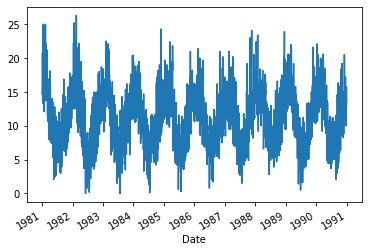

In [27]:
dataset.plot()
plt.show()

# Processing Time-series Data

In [28]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [29]:
lag = 1

raw_values = dataset.values
diff_values = difference(raw_values, 1)

diff_values

0      -2.8
1       0.9
2      -4.2
3       1.2
4       0.0
       ... 
3644   -0.6
3645   -0.4
3646   -0.1
3647    2.2
3648   -2.7
Length: 3649, dtype: float64

In [30]:
supervised = timeseries_to_supervised(diff_values, lag)
supervised

,0,0
0,NaN,-2.8
1,-2.8,0.9
2,0.9,-4.2
3,-4.2,1.2
4,1.2,0.0
...,...,...
3644,1.7,-0.6
3645,-0.6,-0.4
3646,-0.4,-0.1
3647,-0.1,2.2


In [31]:
supervised_values = supervised.values[lag:,:]
supervised_values

array([[-2.8,  0.9],
       [ 0.9, -4.2],
       [-4.2,  1.2],
       ...,
       [-0.4, -0.1],
       [-0.1,  2.2],
       [ 2.2, -2.7]])

In [32]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [33]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) # Range hasil scaling menjadi angka diantara -1 hingga 1
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

# BaseLine Model

In [34]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0563
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0549
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0547
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0546
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0546
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0595 - val_loss: 0.0544
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0593 - val_loss: 0.0543
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0543
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0542
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0542

In [35]:
loss = model.evaluate(feature_test, label_test, verbose=2)

print("Test loss:", loss)

29/29 - 0s - loss: 0.0540
Test loss: 0.053981129080057144


In [36]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

In [37]:
history_dataframe = pd.DataFrame(history.history)
history_dataframe['epoch'] = history.epoch
history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
383,0.058803,0.053975,383
575,0.058802,0.053976,575
729,0.058778,0.053976,729
610,0.058777,0.053976,610
664,0.058755,0.053976,664
...,...,...,...
4,0.059648,0.054558,4
3,0.059817,0.054632,3
2,0.060016,0.054710,2
1,0.060630,0.054917,1


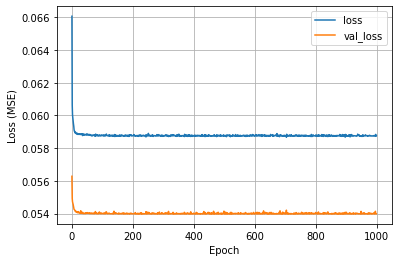

In [38]:
plot_loss(history) # epoch vs loss graph

# Deeper Model

In [39]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0684 - val_loss: 0.0604
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0580
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0567
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0562
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0561
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0561
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0559
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0560

In [40]:
deeper_history_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_history_dataframe['epoch'] = deeper_model_history.epoch
deeper_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
848,0.060661,0.055938,848
729,0.060681,0.055938,729
991,0.060670,0.055938,991
993,0.060675,0.055938,993
675,0.060668,0.055938,675
...,...,...,...
45,0.060752,0.056167,45
3,0.061267,0.056199,3
2,0.062181,0.056688,2
1,0.064115,0.057991,1


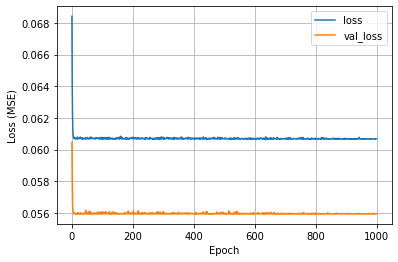

In [41]:
plot_loss(deeper_model_history) # epoch vs loss graph

# Wider Model

In [42]:
neurons = 50
epoch = 1000
batch_size = 32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0542
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0540
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0585 - val_loss: 0.0540
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0538
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0546
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0583 - val_loss: 0.0541
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0538
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0538
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0537
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0538

In [43]:
wider_history_dataframe = pd.DataFrame(wider_model_history.history)
wider_history_dataframe['epoch'] = wider_model_history.epoch
wider_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
11,0.058058,0.053727,11
23,0.058196,0.053740,23
21,0.058206,0.053750,21
8,0.058154,0.053750,8
14,0.057984,0.053757,14
...,...,...,...
984,0.057381,0.054482,984
860,0.057396,0.054490,860
510,0.057535,0.054505,510
4,0.058205,0.054571,4


# LSTM Model

In [21]:
from tensorflow.keras.layers import LSTM

epoch = 1000
batch_size = 32

# Reshape menjadi (jumlah sample, time steps, jumlah feature)
# Time steps: jumlah lag, gunakan default 1
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 4ms/step - loss: 0.0650 - val_loss: 0.0547
Epoch 2/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0541
Epoch 3/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0540
Epoch 4/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0539
Epoch 5/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0539
Epoch 6/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0540
Epoch 7/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0541
Epoch 8/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0539
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0539
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0538

In [22]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
359,0.057801,0.053761,359
350,0.057800,0.053767,350
322,0.057826,0.053775,322
395,0.057757,0.053776,395
483,0.057736,0.053777,483
...,...,...,...
70,0.057997,0.054213,70
126,0.057890,0.054350,126
65,0.057933,0.054383,65
84,0.057991,0.054386,84


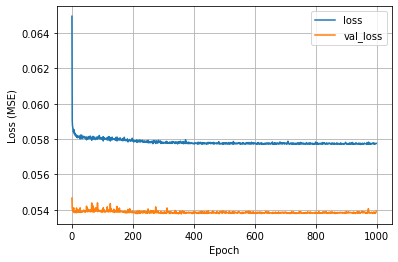

In [23]:
plot_loss(lstm_model_history)

# Kesimpulan

Pada datasets Daily-Min-Temperature Model terbaik yaitu Wider Model dan LSTM namun Wider Model mendapatkan hasil terbaik pada Epoch 11 dengan nilai loss: 0.0582 - val_loss: 0.0538 sedangkan LSTM Model mendapatkan hasil terbaik pada Epoch 359 dengan nilai loss: 0.0578 - val_loss: 0.0538